In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prepare import *
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from metrics import *
from sklearn.ensemble import RandomForestRegressor
from trasnformer import *

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
def invert_sq(x):
    return x ** 2

def inv(x):
    return x

In [224]:
data = pd.read_csv("../data/train.csv")
#data = data[data["Sales"] < 2000]
data = remove_outliers(data)

# transformer.fit_scaler(X)
# X = transformer.scale(X)

Int64Index([14166, 17252, 18146, 18690], dtype='int64')


In [225]:
y = data["Sales"]
X = data

X_reg = np.array([(data["Days with sales"] ** 0.5).values, (data["Comments"] ** 0.5).values])
X_reg = X_reg.T

regressor = LinearRegression().fit(X_reg, np.log1p(data["Sales"]))
print(regressor.score(X_reg, np.log1p(data["Sales"])), regressor.coef_)
res = regressor.predict(X_reg)

X["Approximate"] = res


#X, y = remove_outliers_split_2(X, y)
y = y ** 0.5


transformer = Transformer()

transformer.fit(X, False)
X = transformer.transform_lgbm(X, False)

rare_sections = X[X["Sales"] < 50]["ExtraSection"]
rare_brands = X[X["Sales"] < 50]["Brand"]

0.3300861255590466 [ 9.15870585 26.03403122]


In [226]:
def replaceSection(x, name, values):
    section = x[name]
    if section in values.values:
        return "Rare"
    return str(section)

X['ExtraSection'] = X.apply(lambda x : replaceSection(x, "ExtraSection", rare_sections), axis=1)
X['Brand'] = X.apply(lambda x : replaceSection(x, "Brand", rare_brands), axis=1)

X.drop(columns=["Sales"], inplace=True)

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, y_train = remove_outliers_split(X_train, y_train)
X_train

Brand                 Seller  Comments  Average price  Days in stock  \
13924  Rare        ВАЙЛДБЕРРИЗ ООО  0.000000        35496.0           31.0   
18651  Rare                     ИП  1.000000         3780.0            5.0   
24328  Rare       ЭКО-ПОСТАВКА ООО  1.732051         2051.5           31.0   
19348  Rare                ИВС ООО  2.236068          187.8           15.0   
22237  Rare                     ИП  0.000000         4095.0            0.0   
...     ...                    ...       ...            ...            ...   
21579  Rare                     ИП  0.000000          493.0           31.0   
5390   Rare      ООО СПУТНИК ТРЕЙД  1.732051          385.0           31.0   
860    Rare           ВЛКГРУПП ООО  2.449490         1077.0           31.0   
15796  Rare  Т.К. ИНКОМТЕХПРОМ ООО  3.872983        10930.0           31.0   
23658  Rare                     ИП  1.414214          286.0            6.0   

       Days with sales  Rating  Basic Sale  Approximate  Discount  \
13924                0     0.0        22.0   -46.742120    4022.0   
18651                2     2.5        25.0    -7.755723    1234.0   
24328                0    -0.5        35.0    -1.649856     547.0   
19348                6     2.5        33.0    33.905899      84.0   
22237                0     0.0         0.0   -46.742120     210.0   
...                ...     ...         ...          ...       ...   
21579                0     0.0         0.0   -46.742120       0.0   
5390                 8    -0.5        10.0    24.254876      42.0   
860                  2     0.5        54.0    29.980338       0.0   
15796                7     1.5        30.0    78.318907    1214.0   
23658                3     2.5        35.0     5.938903       0.0   

      ExtraSection  Price scale  
13924         Rare    -0.089404  
18651         Rare    -0.092678  
24328         Rare    -0.202188  
19348         Rare    -0.498057  
22237         Rare     0.378757  
...            ...          ...  
21579         Rare    -0.307057  
5390          Rare    -0.468745  
860           Rare    -0.431281  
15796         Rare     0.160187  
23658         Rare    -0.399509  

[20046 rows x 12 columns]

In [219]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]

train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

org_params = {
    'iterations': 2000,
    'learning_rate': 0.08,
    'eval_metric': 'SMAPE',
    'random_seed': 42,

    'loss_function': 'MAPE',

    #'logging_level': 'Silent',
    #'use_best_model': True,
    #'od_type': 'Iter',
    #'od_wait': 1000,
    #'one_hot_max_size': 20,
    #'l2_leaf_reg': 100,
    #'depth': 8,
    #'rsm': 0.6,
    #'random_strength': 2,
    #'bagging_temperature': 10,
    #'task_type': "GPU",  
    #'devices': '0:1'
}

cat_model = CatBoostRegressor(**org_params)
cat_model.fit(train_pool, eval_set=dev_pool, verbose=0, plot=True, early_stopping_rounds=120)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [214]:
evaluate(cat_model, X_train, y_train, invert_sq)

evaluate(cat_model, X_test, y_test, invert_sq)

SMAPE: 21.282098040861275
SMAPE: 22.80712092396433


In [201]:
cat_model.get_feature_importance(prettified = True)


Feature Id  Importances
0   Days with sales    73.994268
1     Days in stock     8.769222
2          Comments     8.293488
3     Average price     2.507072
4        Basic Sale     1.612425
5       Price scale     1.435376
6          Discount     1.205091
7            Rating     1.129910
8      ExtraSection     1.053148
9             Brand     0.000000
10           Seller     0.000000

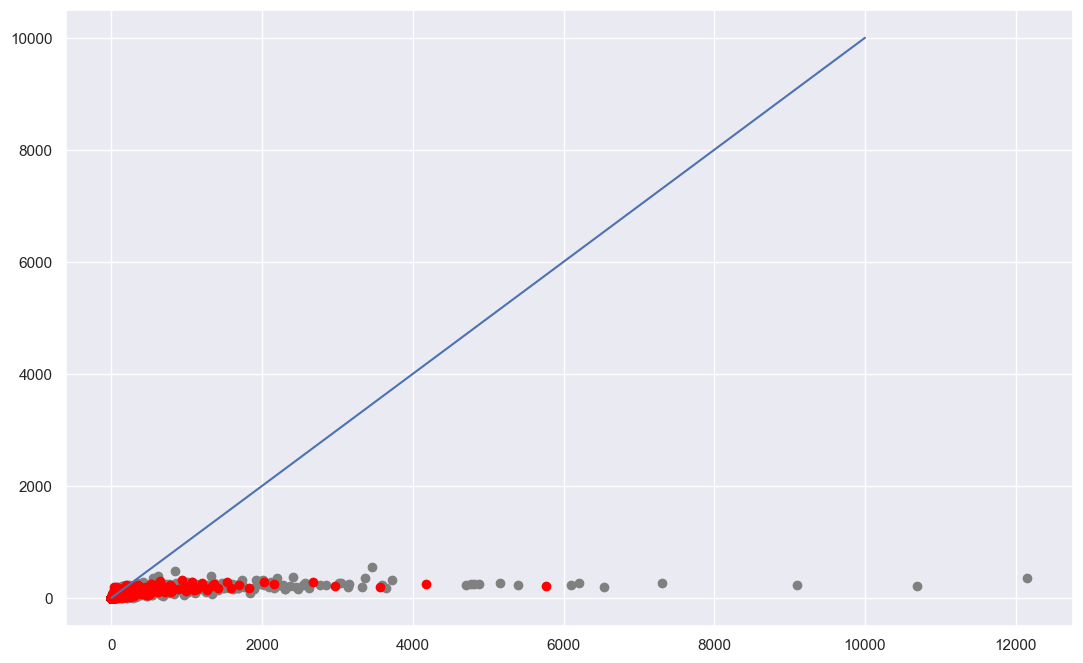

In [202]:
plt.figure(figsize=(13,8))

plt.plot(np.linspace(0, 10000, 2), np.linspace(0, 10000, 2), c = 'b')

plt.scatter(invert_sq(y_train), invert_sq(cat_model.predict(X_train)), color='gray')
plt.scatter(invert_sq(y_test), invert_sq(cat_model.predict(X_test)), color='red')


In [194]:
val_data = pd.read_csv("../data/test.csv")

val_data = prepare_data(val_data).drop(columns=["Id"])
res = cat_model.predict(val_data)
save_res(res)
val_data.head()

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=10]="Техника для кухни": Cannot convert 'b'\xd0\xa2\xd0\xb5\xd1\x85\xd0\xbd\xd0\xb8\xd0\xba\xd0\xb0 \xd0\xb4\xd0\xbb\xd1\x8f \xd0\xba\xd1\x83\xd1\x85\xd0\xbd\xd0\xb8'' to float